# Analyzer

Statistically and visually compare mRNA and lncRNA sequences from GenCode.v38.

Assume user downloaded files from GenCode38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

## Import Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import gzip
from scipy.stats import chisquare, kstest
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load GenCode Data
Loads GenCode.v38 data.

Filters out mRNA sequences based on UTR check.

In [2]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


## Process Sequences
Sampling, binning, length constraints, etc.


In [3]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 200   #Minimum inclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 1             #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [4]:
if APPLY_SUBSET:
  pcdf = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)
  ncdf = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)

  print('PC sample size:', len(pcdf))
  print('NC sample size:', len(ncdf))

PC sample size: 70825
NC sample size: 48752


In [5]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [6]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
  pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
  nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

  print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
  print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (200 - 4000): 55381
NC seqs in length range (200 - 4000): 46912


## Generate Statistics


Using KmerTools to get the K-mer counts upto 3.
It returns the value in Dictionary form. (Key-Value Pair)

In [7]:
MAX_K = 3
tool = KmerTools()
pc_counts = tool.make_dict_upto_K(MAX_K)
for sample in pc_sequences:
    tool.update_count_one_K(pc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(pc_counts,MAX_K)
print("PC counts:\n",pc_counts)
pc_freqs = tool.count_to_frequency(pc_counts,MAX_K)
print ("Frequency:\n",pc_freqs)

nc_counts = tool.make_dict_upto_K(MAX_K)
for sample in nc_sequences:
    tool.update_count_one_K(nc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(nc_counts,MAX_K)
print("NC counts:\n",nc_counts)
nc_freqs = tool.count_to_frequency(nc_counts,MAX_K)
print ("Frequency:\n",nc_freqs)

#Garbage collection
pc_counts = None
nc_counts = None

PC counts:
 {'A': 27438043, 'C': 26672644, 'G': 27285489, 'T': 25795941, 'AA': 7861090, 'AC': 5526911, 'AG': 8138248, 'AT': 5884259, 'CA': 7882687, 'CC': 7944871, 'CG': 3107027, 'CT': 7728575, 'GA': 7485795, 'GC': 6980702, 'GG': 7647850, 'GT': 5162081, 'TA': 4189278, 'TC': 6210051, 'TG': 8370689, 'TT': 7016622, 'AAA': 2584373, 'AAC': 1394697, 'AAG': 2260653, 'AAT': 1608454, 'ACA': 1817696, 'ACC': 1613530, 'ACG': 605594, 'ACT': 1488256, 'AGA': 2442845, 'AGC': 2070291, 'AGG': 2142245, 'AGT': 1480385, 'ATA': 1109852, 'ATC': 1319297, 'ATG': 1861462, 'ATT': 1591831, 'CAA': 1807938, 'CAC': 1657493, 'CAG': 2777993, 'CAT': 1633426, 'CCA': 2349134, 'CCC': 2227044, 'CCG': 1030214, 'CCT': 2335886, 'CGA': 633797, 'CGC': 887842, 'CGG': 1030748, 'CGT': 554124, 'CTA': 1015917, 'CTC': 1940659, 'CTG': 2921538, 'CTT': 1848249, 'GAA': 2287415, 'GAC': 1458212, 'GAG': 2309074, 'GAT': 1426982, 'GCA': 1874139, 'GCC': 2196202, 'GCG': 903136, 'GCT': 2005229, 'GGA': 2353521, 'GGC': 2056026, 'GGG': 1961547, 'GGT

This function takes a dictionary as a parameter. It checks the length of the key to determine if it is 1-mer, 2-mer or 3 mer and assign the values respectively. 

In [8]:
def get_stats(dict):
  one_mer = []
  one_mer_key = []
  two_mer= []
  two_mer_key=[]
  three_mer= []
  three_mer_key=[]
  for sequence in enumerate(dict.items()):
    if(len(sequence[1][0])==1):
      one_mer.append(sequence[1][1])
      one_mer_key.append(sequence[1][0])
    if(len(sequence[1][0])==2):
      two_mer.append(sequence[1][1])
      two_mer_key.append(sequence[1][0])
    if(len(sequence[1][0])==3):
      three_mer.append(sequence[1][1])
      three_mer_key.append(sequence[1][0])
  return one_mer_key, one_mer, two_mer_key,two_mer, three_mer_key, three_mer

In [9]:
#Gets the list  of 1-mer, 2-mer and 3-mer counts along with their key
#In the order of Key-Value. 
pc_stats = get_stats(pc_freqs)
nc_stats = get_stats(nc_freqs)

#1-mer
one_mer_pc = np.asarray(pc_stats[1])
one_mer_nc = np.asarray(nc_stats[1])
#2-mer
two_mer_pc = np.asarray(pc_stats[3])
two_mer_nc = np.asarray(nc_stats[3])
#3-mer
three_mer_pc = np.asarray(pc_stats[5])
three_mer_nc = np.asarray(nc_stats[5])

#Keys that can be used as labels.
one_mer_keys = pc_stats[0]
two_mer_keys = pc_stats[2]
three_mer_keys = pc_stats[4]

In [10]:
print(one_mer_keys)
print(one_mer_pc)
print(one_mer_nc)

['A', 'C', 'G', 'T']
[0.25597072 0.24883028 0.25454753 0.24065147]
[0.27973637 0.22868477 0.22859108 0.26298778]


In [11]:
oc = ORF_counter()

pc_max_orf_len = np.empty(1, dtype=object)
nc_max_orf_len = np.empty(1, dtype=object)
pc_max_orf_len[0] = np.zeros(len(pc_sequences))
nc_max_orf_len[0] = np.zeros(len(nc_sequences))

for i in range(len(pc_sequences)):
  oc.set_sequence(pc_sequences[i])
  pc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(nc_sequences)):
  oc.set_sequence(nc_sequences[i])
  nc_max_orf_len[0][i] = oc.get_max_orf_len()

Using Correlation to see if the total length of series have any relation to the length of ORF. 

In [12]:
pc_seq_len = []
for i in range(len(pc_sequences)):
  pc_seq_len.append(len(pc_sequences[i]))
pc_seq_len = np.asarray(pc_seq_len)
pc_seq_len_orf_len_corrcoef = np.corrcoef(pc_seq_len, pc_max_orf_len[0])

In [13]:
nc_seq_len = []
for i in range(len(nc_sequences)):
  nc_seq_len.append(len(nc_sequences[i]))
nc_seq_len = np.asarray(nc_seq_len)
nc_seq_len_orf_len_corrcoef = np.corrcoef(nc_seq_len, nc_max_orf_len[0])

KS-Similarity Test
Not sure how it works but lets give it a shot. 

In [14]:
x = kstest(two_mer_pc, "norm")
print(x)

KstestResult(statistic=0.5115679341926332, pvalue=0.00020704247837182745)


## Results

In [15]:
data_set_names = ['mRNA', 'lncRNA']

In [16]:
pg = PlotGenerator()
pg.set_text_options(90, 'right', 0, 'center', 12)

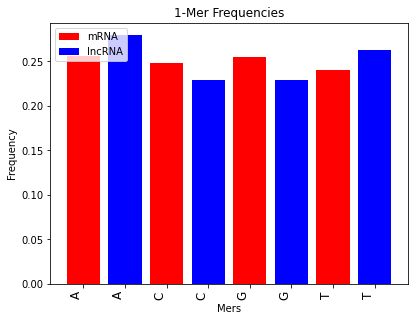

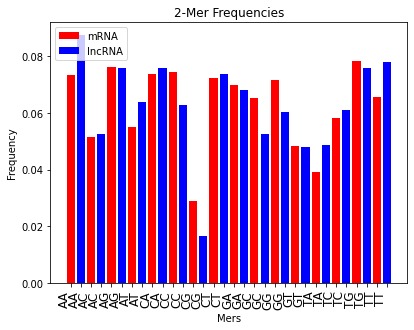

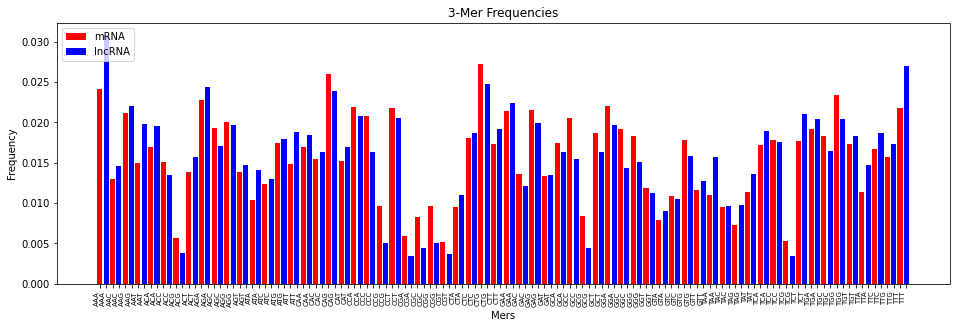

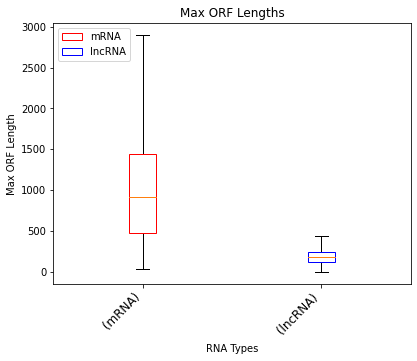

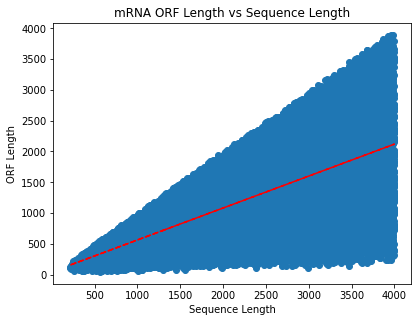

mRNA Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.71390581]
 [0.71390581 1.        ]]


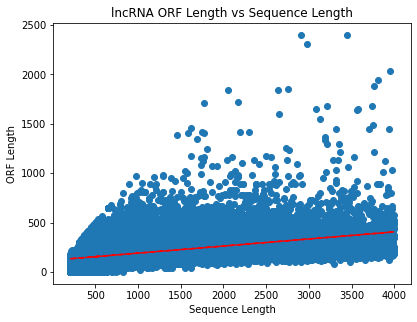

lnc Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.46745122]
 [0.46745122 1.        ]]


In [17]:
pg.set_text('1-Mer Frequencies', 'Mers', 'Frequency', one_mer_keys, None)
pg.bar_plot([one_mer_pc, one_mer_nc], data_set_names)

pg.set_text('2-Mer Frequencies', 'Mers', 'Frequency', two_mer_keys, None)
pg.bar_plot([two_mer_pc, two_mer_nc], data_set_names)

pg.set_figure_options(width=16)
pg.set_text_options(90, 'right', 0, 'center', 7)
pg.set_text('3-Mer Frequencies', 'Mers', 'Frequency', three_mer_keys, None)
pg.bar_plot([three_mer_pc, three_mer_nc], data_set_names)

pg.set_figure_options()
pg.set_text_options(45, 'right', 0, 'center', 12)
pg.set_text('Max ORF Lengths', 'RNA Types', 'Max ORF Length', [''], None)
pg.box_plot([pc_max_orf_len, nc_max_orf_len], data_set_names, False)

pg.set_text('mRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(pc_seq_len, pc_max_orf_len[0], trendline=True)
print('mRNA Sequence Length ORF Length Correlation Coefficient:')
print('\t', pc_seq_len_orf_len_corrcoef)

pg.set_text('lncRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(nc_seq_len, nc_max_orf_len[0], trendline=True)
print('lnc Sequence Length ORF Length Correlation Coefficient:')
print('\t', nc_seq_len_orf_len_corrcoef)